<a href="https://colab.research.google.com/github/zy366lou/Segmentation/blob/main/CityScapeFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import pairwise_distances_argmin
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, UpSampling2D, Concatenate, Input, Softmax
from tensorflow.keras import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


**Sample image.**\
**The image size is 512 by 256. The origianl image is on the left and the mask is on the right. Checking the rgb value of the mask, we can see that there are 14308 unique colors. Therefore, I performed K-means clustering on the mask from a large image combined with 77 masks and reduce the color to 13 categories. These rgb values are stored in the variable unique_color_map. **

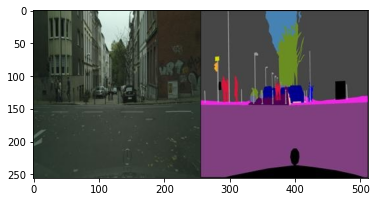

width:   512
height:  256
channel: 3


In [ ]:
# display sample image
img_sample = cv2.imread('/content/drive/My Drive/cityScape/test/10.jpg')
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(img_sample)
plt.show()
h, w, c = img_sample.shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

In [ ]:
# image properties
HEIGHT = 256
WIDTH = 256
N_CLASSES = 13
BATCH_SIZE = 20
EPOCHS = 15

In [ ]:
#split image pairs to image and mask
def loadImage(path, name):
  img = cv2.imread(path + name)
  img = img[:,:,::-1]  # cv2 reads in bgr. Convert it to rgb
  image = img[:,:256]
  #mask = img[:,256:]
  return image

def loadMask(path, name):
  img = cv2.imread(path + name)
  img = img[:,:,::-1]
  #image = img[:,:256]
  mask = np.reshape(img[:,256:], (256,256,3))
  return mask


In [ ]:
train_dir = '/content/drive/My Drive/cityScape/train/'
val_dir = '/content/drive/My Drive/cityScape/validation/'
test_dir = '/content/drive/My Drive/cityScape/test/'
# get the number of pictures in the train and validation folder
train_num = len(os.listdir(train_dir))
val_num = len(os.listdir(val_dir))

Number of Unique Color before Kmeans: 10185
Number of Unique Color after Kmeans: 13


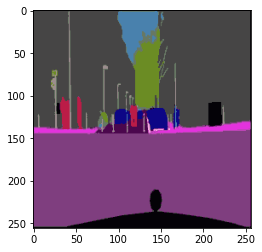

In [ ]:
# perform kmeans image segmentation on masks
def Img_Kmeans_Seg (n_colors, image):
  ColorMsg = str(len(np.unique(image.reshape(-1, image.shape[2]), axis=0)))
  print('Number of Unique Color before Kmeans: '+ ColorMsg)
  image = np.array(image, dtype= np.float64)/255
  w, h, d = original_shape = tuple(image.shape)
  assert d == 3
  mask_vectorised = np.reshape(image,(w*h,d))
  image_array_sample = shuffle(mask_vectorised, random_state=0)[:1000]
  kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
  labels = kmeans.predict(mask_vectorised)
  # K means segmented image display
  d = kmeans.cluster_centers_.shape[1]
  image_kmeans = np.zeros((w, h, d))
  label_idx = 0
  for i in range(w):
     for j in range(h):
         image_kmeans[i][j] = kmeans.cluster_centers_[labels[label_idx]]
         label_idx += 1
  return image_kmeans

#single image test
path = train_dir
name = '10.jpg'
img = cv2.imread(path + name)
mask = np.reshape(img[:,256:], (256,256,3))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
b = Img_Kmeans_Seg(N_CLASSES,mask)
plt.imshow(b)
ColorMsg = str(len(np.unique(b.reshape(-1, b.shape[2]), axis=0)))
print('Number of Unique Color after Kmeans: '+ ColorMsg)

In [ ]:
# combine 77 images to perform K means clustering, out put is a clustered image
def get_mask_color_maps(path, n_colors):
  names = os.listdir(path)
  mask1 = cv2.imread(test_dir+'1.jpg') 
  mask1 = np.reshape(mask1[:,256:], (256,256,3))
  for name in names:
    img = cv2.imread(path + name)
    mask_temp = np.reshape(img[:,256:], (256,256,3))
    mask_temp = cv2.cvtColor(mask_temp, cv2.COLOR_BGR2RGB)
    mask1 = np.append(mask1,mask_temp, axis=0)
    
  img_kmeans = Img_Kmeans_Seg(n_colors,mask1)
  img_kmeans = img_kmeans * 255
  mask_seg = img_kmeans.astype(np.uint8)
  return mask_seg

In [ ]:
#Based on clustering result, get the most common color maps
#13 Classes(colors) 
c = get_mask_color_maps(test_dir, N_CLASSES)
unique_color_map = np.unique(c.reshape(-1, c.shape[2]), axis=0)
print(unique_color_map)

Number of Unique Color before Kmeans: 346613
[[  2   6 133]
 [  5   3   6]
 [ 69  70  68]
 [ 76 131 173]
 [ 83  10  72]
 [106 141  35]
 [111 131  76]
 [128  63 127]
 [159 243 155]
 [197  31  63]
 [211 213  20]
 [212 160 182]
 [235  40 223]]


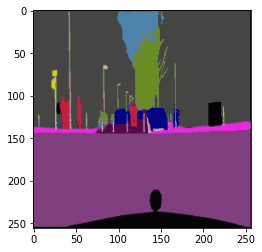

In [ ]:
from scipy.spatial import cKDTree

mask_path = test_dir

label = cv2.imread(test_dir+'10.jpg')
mask = np.reshape(label[:,256:], (256,256,3))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
img = mask
# Input image : img; map image color to the colormap
out_img = unique_color_map[cKDTree(unique_color_map).query(img,k=1)[1]]

plt.imshow(out_img)
plt.show()

In [ ]:
unique_color__ = np.unique(out_img.reshape(-1, out_img.shape[2]), axis=0)
print(unique_color__)

[[  2   6 133]
 [  5   3   6]
 [ 69  70  68]
 [ 76 131 173]
 [ 83  10  72]
 [106 141  35]
 [111 131  76]
 [128  63 127]
 [197  31  63]
 [211 213  20]
 [212 160 182]
 [235  40 223]]


In [ ]:
#create mask: convert rgb image to matrix with 0-12 values
def create_mask(label):
  
  map = [];
  for color in unique_color_map:
    class_map = tf.reduce_all(tf.equal(label,color),axis = -1)
    map.append(class_map)
  
  map = tf.stack(map, axis=-1)
  map = tf.cast(map, tf.float32)
  mask_ = tf.argmax(map, axis=-1)
  mask_ = mask_.numpy()

  return mask_

mask_test = create_mask(out_img)
type(mask_test)

numpy.ndarray

In [ ]:
#create on hot segmentation labels
def get_one_hot_label(mask_, classes, width=WIDTH, height=HEIGHT):
  seg_labels = np.zeros((height, width, classes))
  img = mask_
  for c in range(classes):
    seg_labels[:,:,c] = (img==c).astype(int)
  return seg_labels

In [ ]:
seg_labels = np.zeros((256, 256, 13))
seg_label_test = get_one_hot_label(mask_test,N_CLASSES)
seg_labels[:,:,1] = (mask_test==1).astype(int)
seg_labels

array([[[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
mask_test

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 2, 2, ..., 2, 2, 1],
       [1, 2, 2, ..., 2, 2, 1],
       ...,
       [1, 7, 7, ..., 7, 7, 4],
       [4, 2, 2, ..., 2, 2, 1],
       [1, 1, 1, ..., 1, 4, 1]])

In [ ]:
seg_labels.shape

(256, 256, 13)

In [ ]:
def give_color_to_seg_img(color_map, seg, n_classes=N_CLASSES):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = color_map
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [ ]:
def data_generator(path, batch_size=BATCH_SIZE, classes = N_CLASSES):
  files = os.listdir(path)
  while True:
    for i in range(0, len(files), batch_size):
      batch_files = files[i:i+batch_size]
      imgs = []
      segs = []
      for file in batch_files:
        image = loadImage(path, file)
        mask  = loadMask(path,file)
        mask  = unique_color_map[cKDTree(unique_color_map).query(mask,k=1)[1]]
        mask_ = create_mask(mask)  
        labels= get_one_hot_label(mask_,N_CLASSES,WIDTH,HEIGHT)

        imgs.append(image)
        segs.append(labels)
      
      yield np.array(imgs), np.array(segs)


In [ ]:
train_gen = data_generator(train_dir)
val_gen = data_generator(val_dir)

In [ ]:
img, seg = next(train_gen)
img.shape, seg.shape

((20, 256, 256, 3), (20, 256, 256, 13))

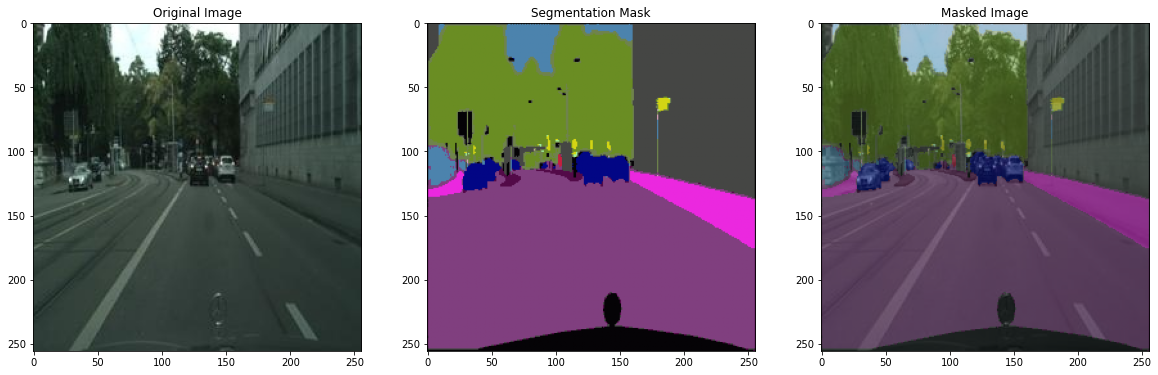

In [ ]:
image = img[0]
mask = give_color_to_seg_img(unique_color_map, np.argmax(seg[0], axis=-1))/255
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plt.show()

In [ ]:
mask.shape


(256, 256, 3)

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((HEIGHT,WIDTH,3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = Conv2D(N_CLASSES, (1, 1), padding="same", activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

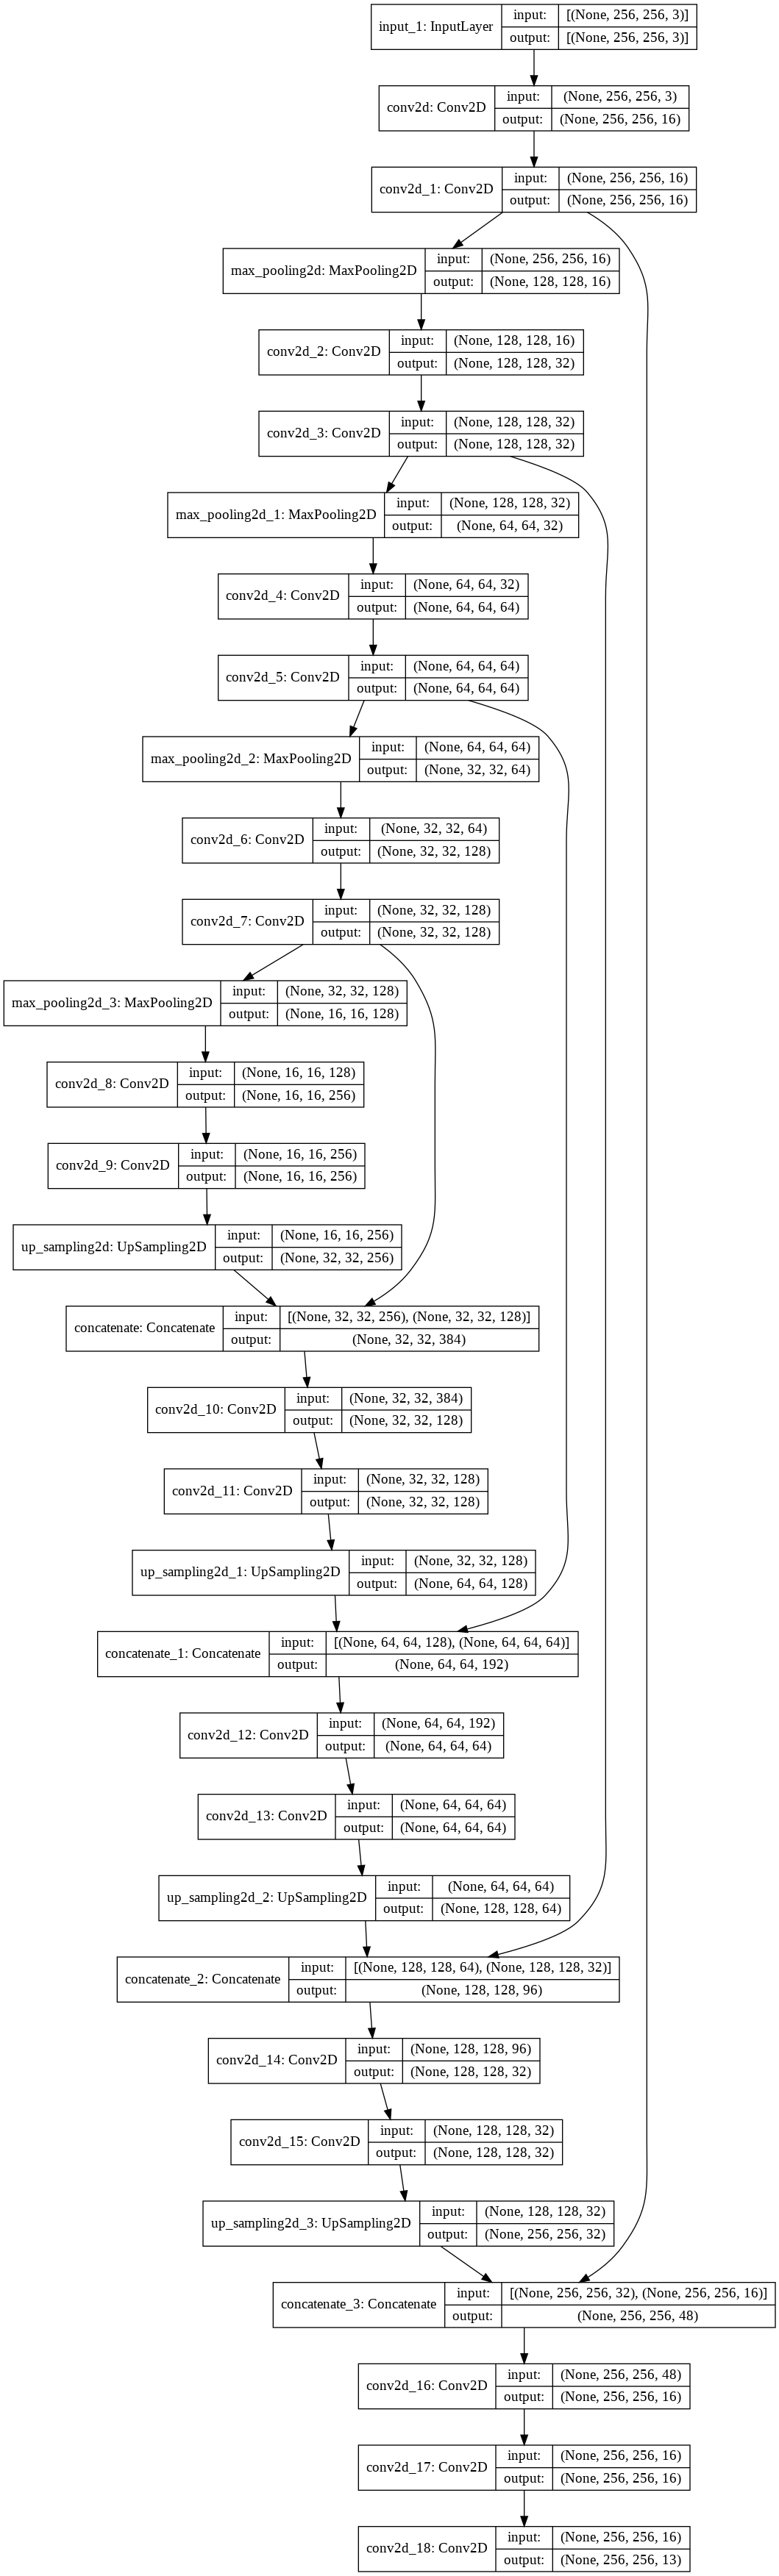

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
TRAIN_STEPS = train_num//BATCH_SIZE+1
VAL_STEPS = val_num//BATCH_SIZE+1

history= model.fit(train_gen, validation_data=val_gen, steps_per_epoch=TRAIN_STEPS, 
                    validation_steps=VAL_STEPS, epochs=EPOCHS )

Epoch 1/15
149/149 [==============================] - 2130s 14s/step - loss: 2.0939 - acc: 0.4537 - val_loss: 1.2102 - val_acc: 0.6495
Epoch 2/15
149/149 [==============================] - 118s 798ms/step - loss: 1.0605 - acc: 0.6985 - val_loss: 0.9674 - val_acc: 0.7203
Epoch 3/15
149/149 [==============================] - 119s 800ms/step - loss: 0.8743 - acc: 0.7477 - val_loss: 0.8677 - val_acc: 0.7490
Epoch 4/15
149/149 [==============================] - 119s 801ms/step - loss: 0.7869 - acc: 0.7741 - val_loss: 0.8165 - val_acc: 0.7640
Epoch 5/15
149/149 [==============================] - 119s 802ms/step - loss: 0.7332 - acc: 0.7893 - val_loss: 0.7726 - val_acc: 0.7740
Epoch 6/15
149/149 [==============================] - 118s 796ms/step - loss: 0.6875 - acc: 0.8020 - val_loss: 0.7643 - val_acc: 0.7794
Epoch 7/15
149/149 [==============================] - 119s 801ms/step - loss: 0.6558 - acc: 0.8103 - val_loss: 0.7419 - val_acc: 0.7825
Epoch 8/15
149/149 [=============================

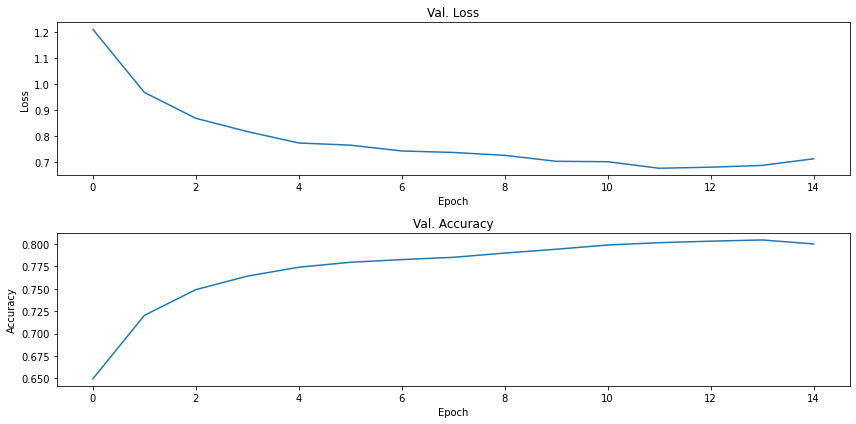

In [ ]:
loss = history.history["val_loss"]
acc = history.history["val_acc"]

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Val. Loss")
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
#plot.savefig("learn.png", dpi=150)
plt.show()

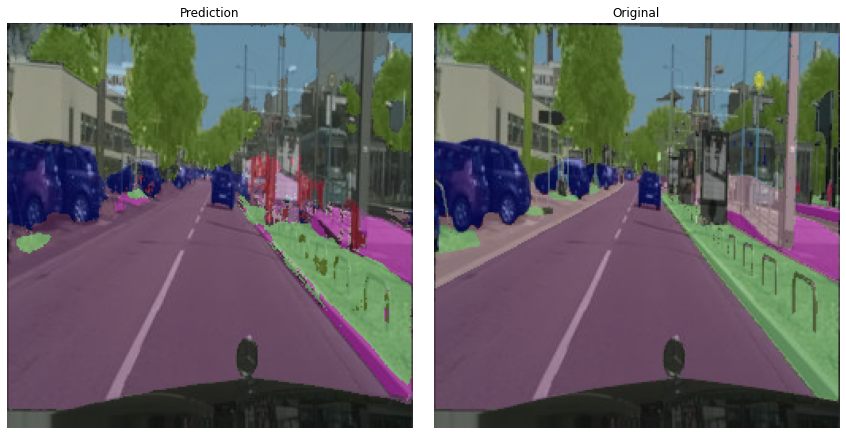

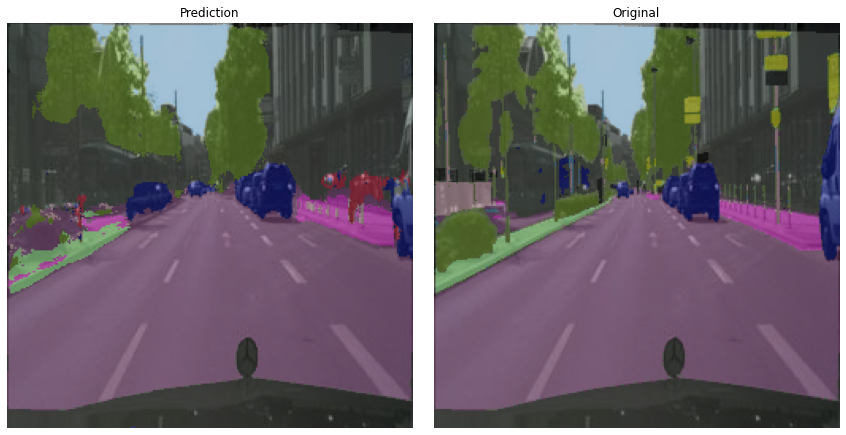

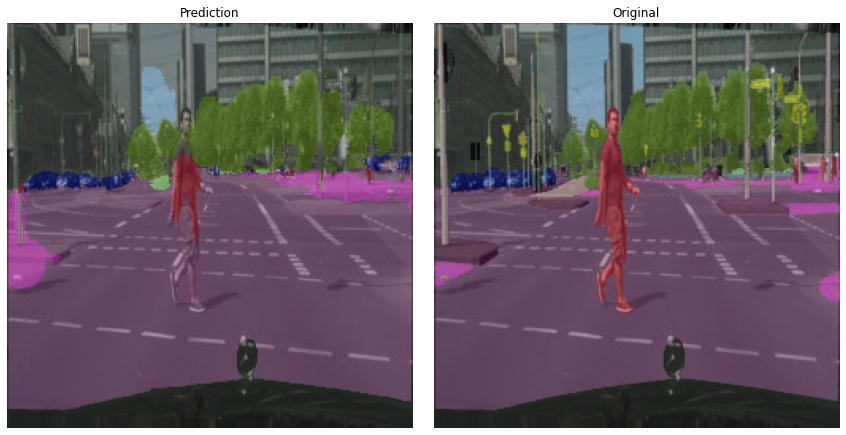

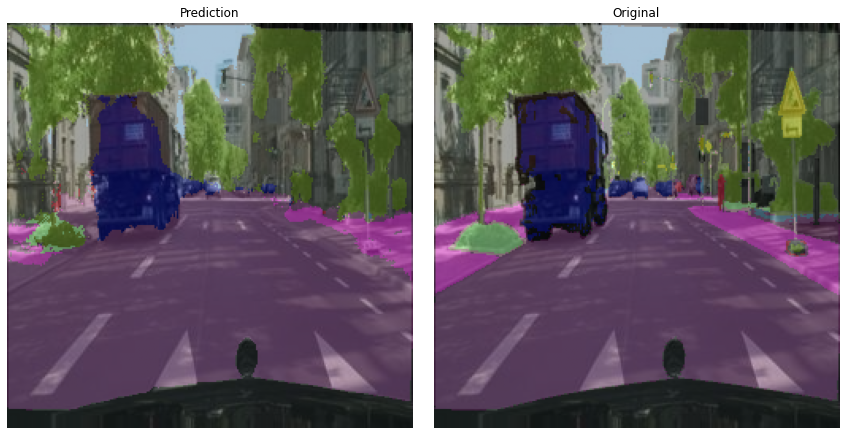

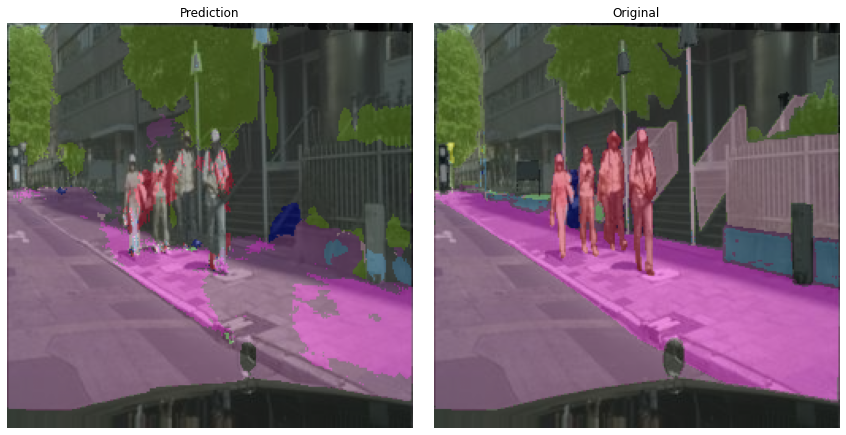

In [ ]:
max_show = 5
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(unique_color_map, np.argmax(pred[i], axis=-1))/255
    _s = give_color_to_seg_img(unique_color_map, np.argmax(segs[i], axis=-1))/255

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)
    
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    plt.subplot(122)
    plt.title("Original")
    plt.imshow(trueimg)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("pred_"+str(i)+".png", dpi=150)
    plt.show()

In [ ]:
#imgplot = plt.imshow(mask)
#unique_color__ = np.unique(out_img.reshape(-1, out_img.shape[2]), axis=0

(-0.5, 255.5, 255.5, -0.5)

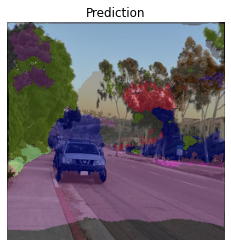

In [ ]:
path = '/content/drive/My Drive/cityScape/SanDiego/'
name = 'ir.jpg'
img = cv2.imread(path + name)
img = img[:,:,::-1]  # cv2 reads in bgr. Convert it to rgb
img_test = []
for i in range(BATCH_SIZE):
  img_test.append(img)

img_test_arr = np.array(img_test)
pred = model.predict(img_test_arr)
_p = give_color_to_seg_img(unique_color_map, np.argmax(pred[1], axis=-1))/255
predimg = cv2.addWeighted(img/255, 0.5, _p, 0.5, 0)
plt.title("Prediction")
plt.imshow(predimg)
plt.axis("off")


In [ ]:
#def get_rgb (path):
#  names = os.listdir(path)
#  mask = np.empty([1,3])
#  for name in names:
#    img = cv2.imread(path+name)
#    mask = loadMask(img)
#    temp_mask = np.unique(mask.reshape(-1, mask.shape[2]), axis=0)
#    mask = np.append(mask, temp_mask, axis=0)


In [ ]:
#https://www.kaggle.com/wongchiensen/segfast-model-semantic-segmentation
#from cityscapesscripts.helpers import labels as helper_labels
#labels = helper_labels.labels
# Print all the labels
#print("List of cityscapes labels:")
#print("")
#print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12} | {:>1}"
#      .format( 'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color' ))
#print("    " + ('-' * 110))
#for label in labels:
#    print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12} | {}".format( label.name, label.id, label.trainId, label.category, label.categoryId, label.hasInstances, label.ignoreInEval, label.color))
#print("")

In [ ]:
# individual image test
#n_colors = 13
#path = train_dir
#name = '13.jpg'
#print(path+name)
#img = cv2.imread(path + name)
#mask = np.reshape(img[:,256:], (256,256,3))
#mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
#print('Number of Unique Color: '+str(len(np.unique(mask.reshape(-1, mask.shape[2]), axis=0))))
#mask = np.array(mask, dtype= np.float64)/255
#w, h, d = original_shape = tuple(mask.shape)
#assert d == 3
#mask_vectorised = np.reshape(mask,(w*h,d))
#image_array_sample = shuffle(mask_vectorised, random_state=0)[:1000]
#kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
#labels = kmeans.predict(mask_vectorised)
#codebook_random = shuffle(mask_vectorised, random_state=0)[:n_colors]
#labels_random = pairwise_distances_argmin(codebook_random,
#                                          mask_vectorised,
#                                          axis=0)
#def recreate_image(codebook, labels, w, h):
#    """Recreate the (compressed) image from the code book & labels"""
#    d = codebook.shape[1]
#    image = np.zeros((w, h, d))
#   label_idx = 0
#    for i in range(w):
#        for j in range(h):
#            image[i][j] = codebook[labels[label_idx]]
#            label_idx += 1
#    return image
#plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))